<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


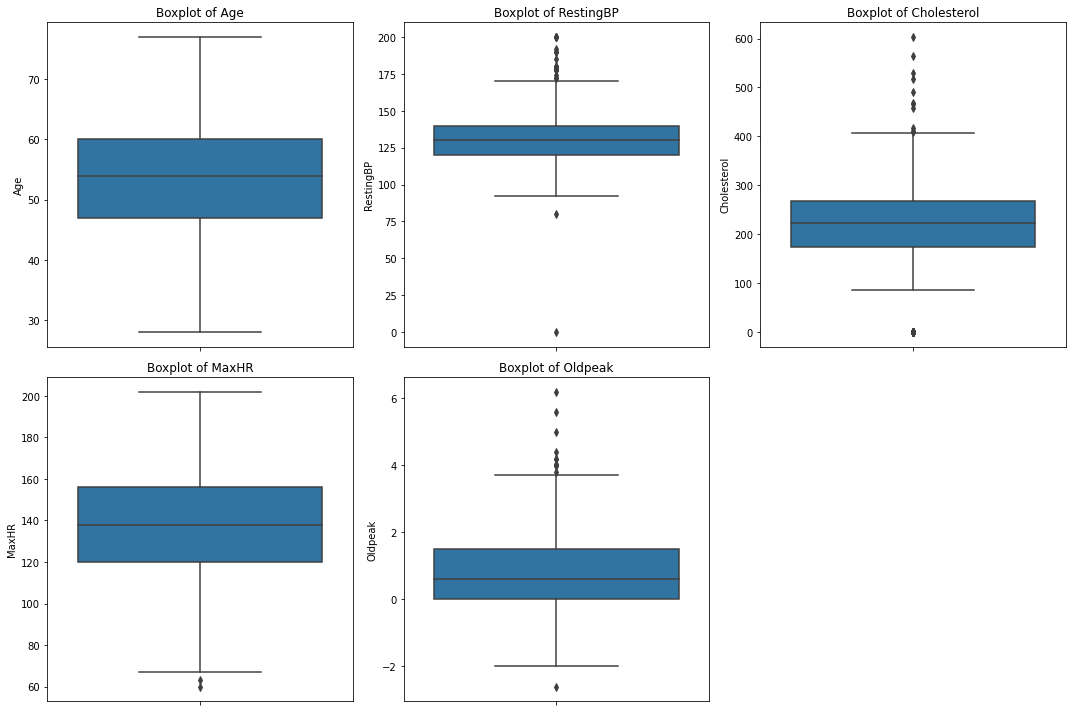

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Load the data
heart_data = pd.read_csv("heart.csv")

# Display the first few rows of the dataset
heart_data_head = heart_data.head()

# Check for missing values and data types
missing_values = heart_data.isnull().sum()
data_types = heart_data.dtypes

# Visualize numeric columns
plt.figure(figsize=(15, 10))
numeric_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=heart_data[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Handle outliers
z_scores = zscore(heart_data[numeric_cols])
z_scores_df = pd.DataFrame(z_scores, columns=numeric_cols)
outliers = z_scores_df[(z_scores_df.abs() > 3).any(axis=1)]
for col in numeric_cols:
    Q1 = heart_data[col].quantile(0.25)
    Q3 = heart_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    heart_data[col] = heart_data[col].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))



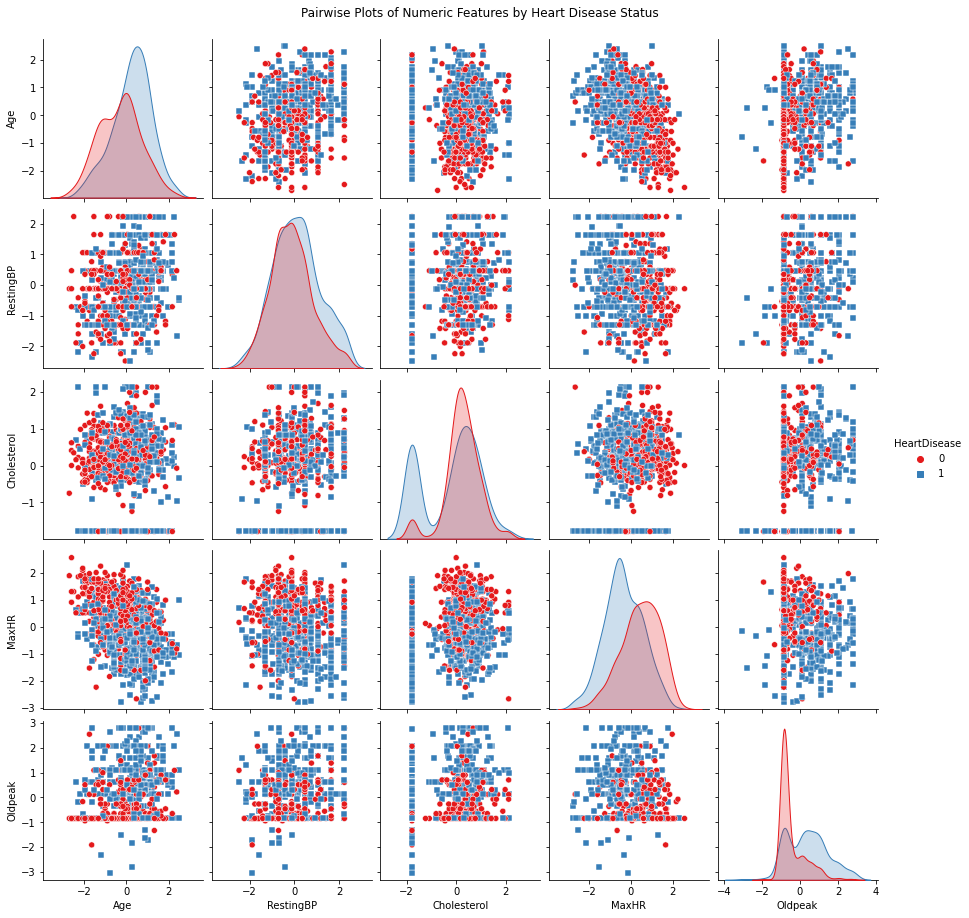

In [2]:
# One-hot encode categorical columns
heart_data_encoded = pd.get_dummies(heart_data, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])

# Scale numeric columns
scaler = StandardScaler()
numeric_cols_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
heart_data_encoded[numeric_cols_to_scale] = scaler.fit_transform(heart_data_encoded[numeric_cols_to_scale])

# Pairwise plots
subset_data = heart_data_encoded[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']]
sns.pairplot(subset_data, hue='HeartDisease', markers=["o", "s"], palette="Set1")
plt.suptitle("Pairwise Plots of Numeric Features by Heart Disease Status", y=1.02)
plt.show()



In [3]:
# Train/test split
X = heart_data_encoded.drop('HeartDisease', axis=1)
y = heart_data_encoded['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train model with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
train_accuracy = best_rf.score(X_train, y_train)
test_accuracy = best_rf.score(X_test, y_test)





Fitting 3 folds for each of 216 candidates, totalling 648 fits


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

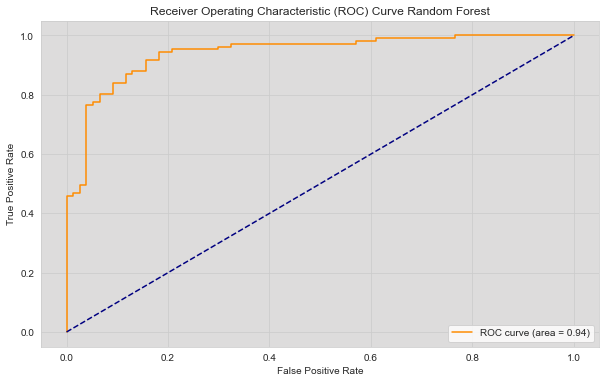

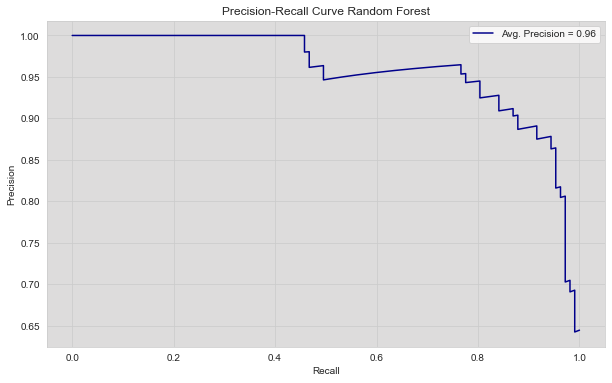

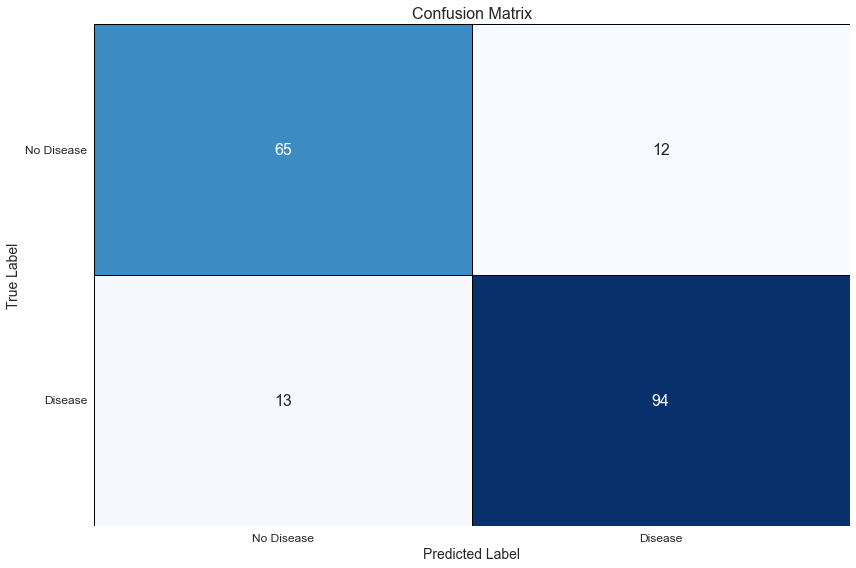

              precision    recall  f1-score   support

           0       0.83      0.84      0.84        77
           1       0.89      0.88      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [4]:
# Set the Seaborn style for the background
sns.set_style("whitegrid")

# Metrics and evaluations for Random Forest
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

# Set the background color
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))  # You can adjust the value inside coolwarm() as needed

plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



# Set the Seaborn style for the background
sns.set_style("whitegrid")

# Precision-Recall Curve for Random Forest
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(10, 6))
# Set the background color for the Precision-Recall Curve
ax = plt.gca()
ax.set_facecolor(plt.cm.coolwarm(0.5))

plt.plot(recall, precision, color='darkblue', label=f'Avg. Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Random Forest')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


# ... [All previous code remains unchanged]

# Predict the outcomes using the best Random Forest model on the test set
y_pred = best_rf.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix with seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Assuming the labels are 'No Disease' and 'Disease' as per the code provided
plt.xticks(ticks=[0.5, 1.5], labels=['No Disease', 'Disease'], fontsize=12)
plt.yticks(ticks=[0.5, 1.5], labels=['No Disease', 'Disease'], fontsize=12, rotation=0)

plt.tight_layout()
plt.show()

report_text = classification_report(y_test, y_pred)
print(report_text)


/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/macos/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:560: 

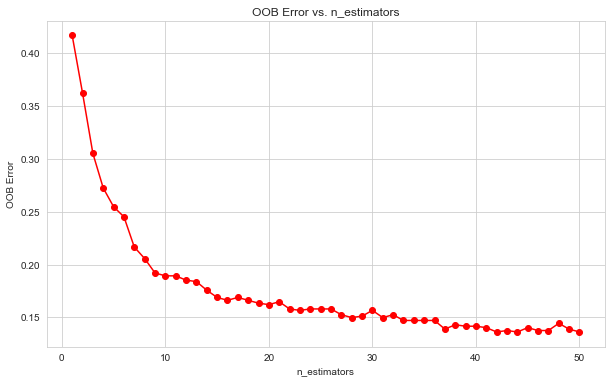

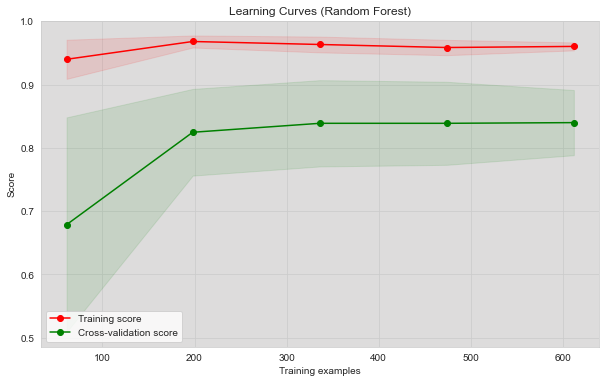

In [5]:
from sklearn.model_selection import learning_curve

# OOB Error plot
def plot_oob_error(X_train, y_train):
    oob_errors = []
    n_estimators_range = range(1, 51)  # Reduced range for computational efficiency
    for n in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n, oob_score=True, bootstrap=True, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        oob_error = 1 - rf.oob_score_
        oob_errors.append(oob_error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, oob_errors, 'o-', color="r")
    plt.xlabel("n_estimators")
    plt.ylabel("OOB Error")
    plt.title("OOB Error vs. n_estimators")
    plt.grid(True)
    plt.show()

plot_oob_error(X_train, y_train)

# Learning curve function
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Set the background color for the Learning Curve
    ax = plt.gca()
    ax.set_facecolor(plt.cm.coolwarm(0.5))
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(best_rf, "Learning Curves (Random Forest)", X, y, cv=3)


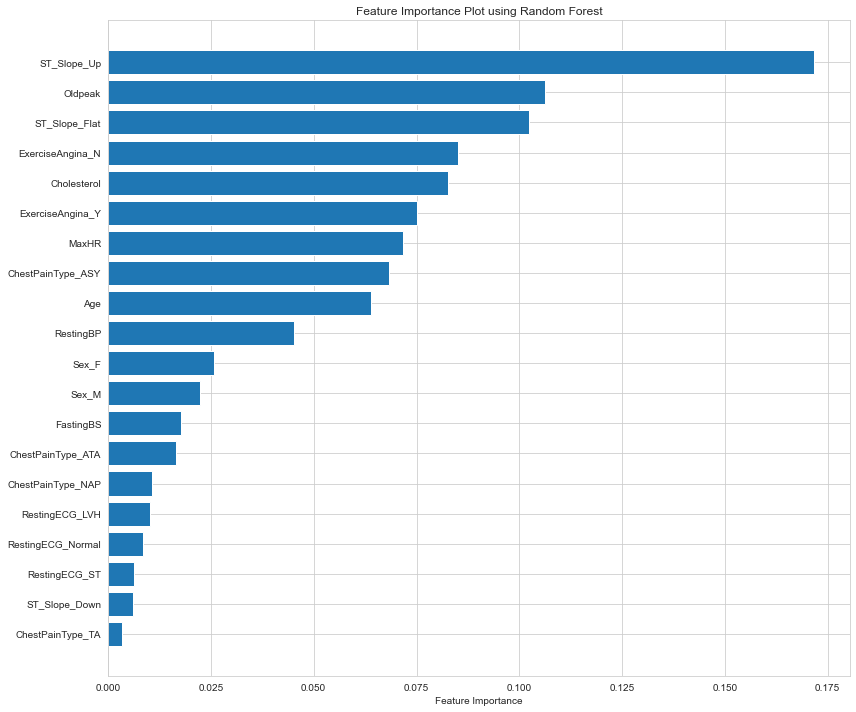

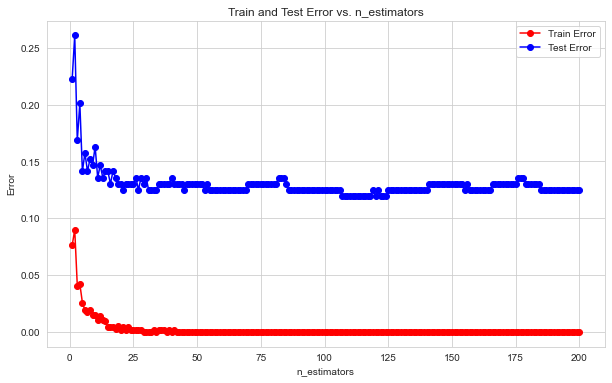

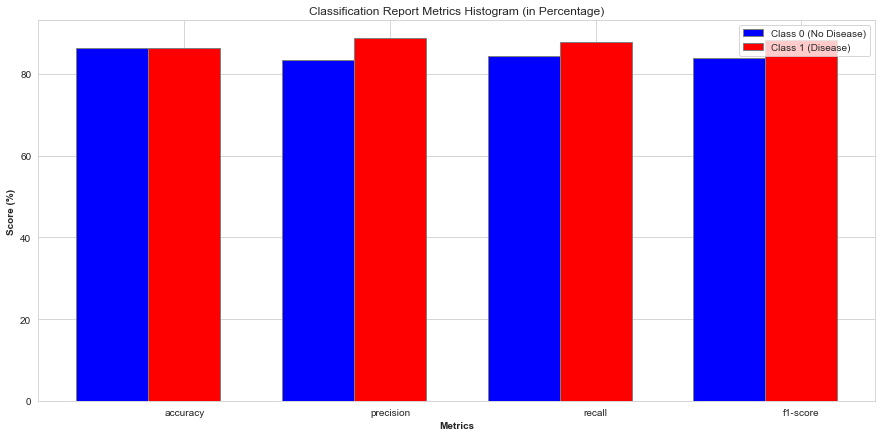

In [6]:
# Feature importance
feature_importances = best_rf.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(12, 10))
plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot using Random Forest')
plt.tight_layout()
plt.show()

# Function to plot Train and Test Error for different numbers of trees (n_estimators)
def plot_train_test_error(X_train, y_train, X_test, y_test):
    train_errors = []
    test_errors = []
    n_estimators_range = range(1, 201)
    for n in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        train_error = 1 - rf.score(X_train, y_train)
        train_errors.append(train_error)
        test_error = 1 - rf.score(X_test, y_test)
        test_errors.append(test_error)
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_errors, 'o-', color="r", label="Train Error")
    plt.plot(n_estimators_range, test_errors, 'o-', color="b", label="Test Error")
    plt.xlabel("n_estimators")
    plt.ylabel("Error")
    plt.title("Train and Test Error vs. n_estimators")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_train_test_error(X_train, y_train, X_test, y_test)


# Calculate the classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Extract accuracy in percentage
accuracy_percent = report['accuracy'] * 100

# Define bar width for the histogram
barWidth = 0.35

# Re-arrange metrics to have 'accuracy' as the first metric
rearranged_metrics = ['accuracy', 'precision', 'recall', 'f1-score']

# Extract and rearrange metrics for both classes
class_0_metrics_rearranged = [report['0'][metric] * 100 if metric != 'accuracy' else accuracy_percent for metric in rearranged_metrics]
class_1_metrics_rearranged = [report['1'][metric] * 100 if metric != 'accuracy' else accuracy_percent for metric in rearranged_metrics]

# Re-plotting the histogram with rearranged metrics
r1_rearranged = np.arange(len(class_0_metrics_rearranged))
r2_rearranged = [x + barWidth for x in r1_rearranged]

plt.figure(figsize=(15, 7))
plt.bar(r1_rearranged, class_0_metrics_rearranged, width=barWidth, color='blue', edgecolor='grey', label='Class 0 (No Disease)')
plt.bar(r2_rearranged, class_1_metrics_rearranged, width=barWidth, color='red', edgecolor='grey', label='Class 1 (Disease)')

plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score (%)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(class_0_metrics_rearranged))], rearranged_metrics)
plt.title('Classification Report Metrics Histogram (in Percentage)')
plt.legend()
plt.show()



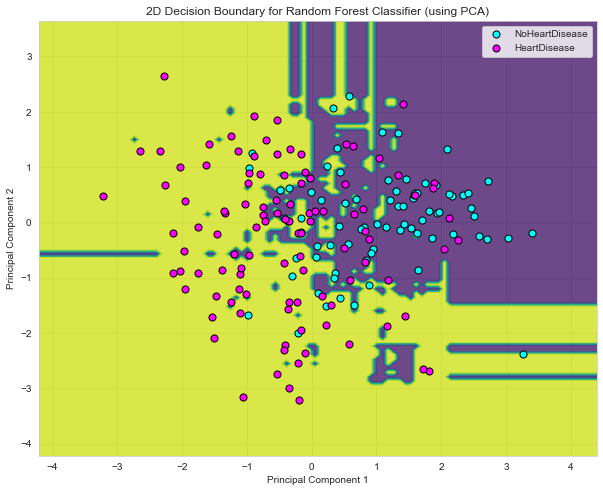

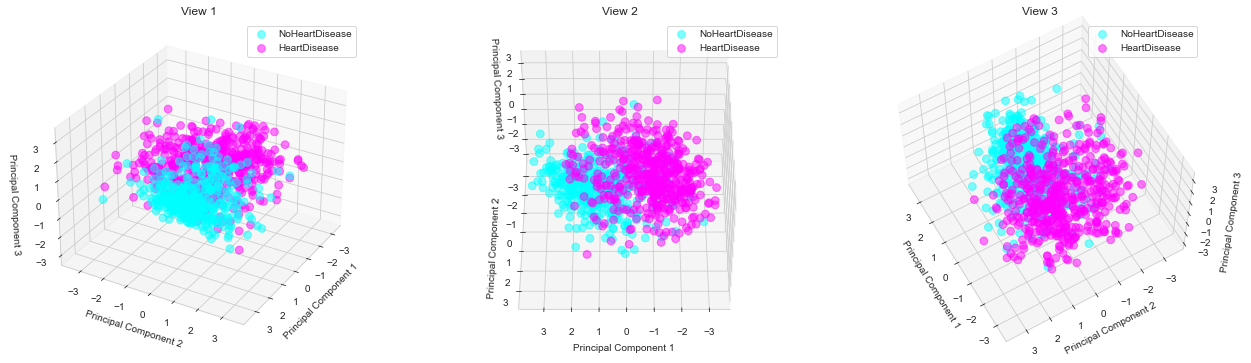

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Define PCA and fit it to the training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Fit Random Forest on the PCA transformed training data
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_pca, y_train)

# Predict class labels for the test data
rf_y_pred = rf_model.predict(X_test_pca)

# Define masks for true classes
mask_true_0 = y_test == 0
mask_true_1 = y_test == 1

# Generate a mesh grid for plotting decision boundaries
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict class labels for each point on the grid
Z_rf = rf_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rf = Z_rf.reshape(xx.shape)

# Plot decision boundaries using contourf function
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z_rf, alpha=0.8, cmap=plt.cm.viridis)
plt.scatter(X_test_pca[mask_true_0, 0], X_test_pca[mask_true_0, 1], color='cyan', label='NoHeartDisease', marker='o', s=50, edgecolor='k')
plt.scatter(X_test_pca[mask_true_1, 0], X_test_pca[mask_true_1, 1], color='magenta', label='HeartDisease', marker='o', s=50, edgecolor='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Decision Boundary for Random Forest Classifier (using PCA)')
plt.legend()
plt.grid(True)
plt.show()

# 3D PCA visualization
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
rf_model.fit(X_pca_3d, y)

fig = plt.figure(figsize=(18, 5))
for idx, angle in enumerate([(30, 30), (45, 90), (60, 150)]):
    ax = fig.add_subplot(1, 3, idx+1, projection='3d')
    ax.scatter(X_pca_3d[y==0, 0], X_pca_3d[y==0, 1], X_pca_3d[y==0, 2], color='cyan', s=60, label='NoHeartDisease', alpha=0.5)
    ax.scatter(X_pca_3d[y==1, 0], X_pca_3d[y==1, 1], X_pca_3d[y==1, 2], color='magenta', s=60, label='HeartDisease', alpha=0.5)
    ax.view_init(elev=angle[0], azim=angle[1])
    ax.set_title(f'View {idx+1}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend()
plt.tight_layout()
plt.show()
